# The bank customer churn prediction

Beta Bank customers are leaving: little by little, chipping away every month. The bankers figured out it’s cheaper to save the existing customers rather than to attract new ones.

We need to predict whether a customer will leave the bank soon. We have the data on clients’ past behavior and termination of contracts with the bank.

We build a model with the maximum possible F1 score. We need an F1 score of at least 0.59.
Additionally, measure the AUC-ROC metric and compare it with the F1.

### Step 1. Open the data file and study the general information

In [1]:
# import libs
import pandas as pd
import numpy as np
%config InlineBackend.figure_format = 'retina' 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

*Read the file with data from "Churn.csv" and save it to the variable*

In [2]:
# read the data
df_bank = pd.read_csv('churn.csv')

*Print 5 random rows*

In [3]:
df_bank.sample(n=5, random_state=12) # use sample() method

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
5669,5670,15706706,Chinwendu,648,Germany,Male,33,7.0,135310.41,2,0,1,171668.20,0
8800,8801,15647890,Su,691,France,Male,37,9.0,149405.18,1,1,1,146411.60,0
3205,3206,15733973,Bibi,850,France,Female,42,8.0,0.00,1,1,0,19632.64,1
8731,8732,15769125,Palerma,727,Spain,Female,41,10.0,0.00,2,0,1,47468.56,0
6412,6413,15598982,Klein,602,Germany,Female,53,5.0,98268.84,1,0,1,45038.29,1


*Data description*

Features:
- RowNumber — data string index
- CustomerId — unique customer identifier
- Surname — surname
- CreditScore — credit score
- Geography — country of residence
- Gender — gender
- Age — age
- Tenure — length of service for customer
- Balance — account balance
- NumOfProducts — number of banking products used by the customer
- HasCrCard — customer has a credit card
- IsActiveMember — customer’s activeness
- EstimatedSalary — estimated salary

Target:
- Exited — сustomer has left

*Look at the general information of our dataset*

In [4]:
df_bank.info() # use info() method

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


*Check the percent of NaN*

In [5]:
(df_bank['Tenure'].isnull()).sum() / 10000 * 100

9.09

*Use describe() method for more information*

Check the numeric values

In [6]:
df_bank.describe().T

,count,mean,std,min,25%,50%,75%,max
RowNumber,10000.0,5.000500e+03,2886.895680,1.00,2500.75,5.000500e+03,7.500250e+03,10000.00
CustomerId,10000.0,1.569094e+07,71936.186123,15565701.00,15628528.25,1.569074e+07,1.575323e+07,15815690.00
CreditScore,10000.0,6.505288e+02,96.653299,350.00,584.00,6.520000e+02,7.180000e+02,850.00
Age,10000.0,3.892180e+01,10.487806,18.00,32.00,3.700000e+01,4.400000e+01,92.00
Tenure,9091.0,4.997690e+00,2.894723,0.00,2.00,5.000000e+00,7.000000e+00,10.00
Balance,10000.0,7.648589e+04,62397.405202,0.00,0.00,9.719854e+04,1.276442e+05,250898.09
NumOfProducts,10000.0,1.530200e+00,0.581654,1.00,1.00,1.000000e+00,2.000000e+00,4.00
HasCrCard,10000.0,7.055000e-01,0.455840,0.00,0.00,1.000000e+00,1.000000e+00,1.00
IsActiveMember,10000.0,5.151000e-01,0.499797,0.00,0.00,1.000000e+00,1.000000e+00,1.00
EstimatedSalary,10000.0,1.000902e+05,57510.492818,11.58,51002.11,1.001939e+05,1.493882e+05,199992.48


Check the quantitative values

In [7]:
df_bank.describe(include='object').T

,count,unique,top,freq
Surname,10000,2932,Smith,32
Geography,10000,3,France,5014
Gender,10000,2,Male,5457


*Check the imbalance of classes.*

In [8]:
print((df_bank['Exited'] == 1).sum() / df_bank.shape[0] * 100)
print((df_bank['Exited'] == 0).sum() / df_bank.shape[0] * 100)

20.369999999999997
79.63


### Conclusion

- We have NaN values in "Tenure". It's 9.09 percent. Just drop it.
- We need to change float type to int in "Tenure".
- We don't need "RowNumber", "CustomerId" and "Surname" columns. Drop them.
- Transform categorical features ("Geography", "Gender") into numerical features with One-Hot Encoding (OHE).
- We have the imbalance of classes and we need to fix it. Use Upsampling technique.

### Step 2. Data preprocessing

Drop NaN, change data types and transform categorical features.

*Drop NaNs in "Tenure" and drop "RowNumber", "CustomerId", "Surname" columns*

In [9]:
df_bank.dropna(subset=['Tenure'], inplace=True) # drop NaN in "Tenure" column
df_bank.drop(columns=['RowNumber', 'CustomerId', 'Surname'], inplace=True) # drop columns

*Replace type in "Tenure" column*

In [10]:
df_bank['Tenure'] = df_bank['Tenure'].astype(int) # replace type with "astype()" method

*Check the values*

In [11]:
df_bank.info() # use info() method

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9091 entries, 0 to 9998
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      9091 non-null   int64  
 1   Geography        9091 non-null   object 
 2   Gender           9091 non-null   object 
 3   Age              9091 non-null   int64  
 4   Tenure           9091 non-null   int32  
 5   Balance          9091 non-null   float64
 6   NumOfProducts    9091 non-null   int64  
 7   HasCrCard        9091 non-null   int64  
 8   IsActiveMember   9091 non-null   int64  
 9   EstimatedSalary  9091 non-null   float64
 10  Exited           9091 non-null   int64  
dtypes: float64(2), int32(1), int64(6), object(2)
memory usage: 816.8+ KB


### Step 3. Feature Preparation

Make OHE, split the data.

*Make One-Hot Encoding of categorical features with "drop_first" parameter for "Geography" column*

In [12]:
df_bank_ohe = pd.get_dummies(df_bank, columns=['Geography'], drop_first=True)
df_bank_ohe = pd.get_dummies(df_bank_ohe, columns=['Gender'])

*Check the results*

In [13]:
df_bank_ohe.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,1,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,1,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,1,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,1,0


*Split "df_bank_ohe" into a training set, a validation set, and a test set*

In [14]:
# use numpy split() method
df_bank_ohe_train, df_bank_ohe_valid, df_bank_ohe_test = (
    np.split(df_bank_ohe.sample(frac=1, random_state=12345),
             [int(.6*len(df_bank_ohe)),
              int(.8*len(df_bank_ohe))])
)

*Check the dataframes*

In [15]:
for i in (df_bank_ohe_train.shape[0],
          df_bank_ohe_valid.shape[0],
          df_bank_ohe_test.shape[0]):
    print(i / df_bank_ohe.shape[0] * 100)

59.99340006599934
19.99780002199978
20.008799912000878


*Create features and target for the training set, the validation set, and the test set*

In [16]:
features_train = df_bank_ohe_train.drop(['Exited'], axis=1)
target_train = df_bank_ohe_train['Exited']

features_valid = df_bank_ohe_valid.drop(['Exited'], axis=1)
target_valid = df_bank_ohe_valid['Exited']

features_test = df_bank_ohe_test.drop(['Exited'], axis=1)
target_test = df_bank_ohe_test['Exited']

### Step 4. Upsampling

Upsampling is performed in several steps:
- Count "1" (positive) and "0" (negative);
- Split the training sample into negative and positive observations;
- Duplicate the positive observations several times;
- Create a new training sample based on the data obtained;
- Shuffle the data: identical questions following one another will not help the training.

*Count "1" and "0"*

In [17]:
ones_count = (target_train == 1).sum() # count "1" values
ones_count

1100

In [18]:
zeros_count = (target_train == 0).sum() # count "0" values
zeros_count

4354

*Count how many times we need to multiply "1"*

In [19]:
repeat = (zeros_count / ones_count).round().astype(int)
repeat

4

*Create the function for upsampling*

In [20]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0] # features of the "0" answer observations
    features_ones = features[target == 1] #  features of the "1" answer observations
    target_zeros = target[target == 0] #  target of the "0" answer observations
    target_ones = target[target == 1] # target of the "1" answer observations

    # Duplicate "1" and combine "0". Use the pd.concat() function to concatenate the tables
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    # Shuffle the data
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

*Make upsampling*

In [21]:
features_train_upsampled, target_train_upsampled = upsample(features_train, target_train, repeat)

*Count "1" and "0"*

In [22]:
ones_count = (target_train_upsampled == 1).sum() # count "1" values
ones_count

4400

In [23]:
zeros_count = (target_train_upsampled == 0).sum() # count "0" values
zeros_count

4354

### Step 5. Сhoosing the best model

We'll try to train "DecisionTreeClassifier", "RandomForestClassifier", "LogisticRegression" and "GradientBoostingClassifier" models. And then we'll compare results.

### Train the model without taking into account the imbalance.

**Train the model with "DecisionTreeClassifier"**

In [24]:
df_decissiontree = pd.DataFrame() # create dataframe
for depth in range(2, 10):
    # create the model
    model = DecisionTreeClassifier(max_depth=depth, random_state=12345)

    # fit the model
    model.fit(features_train, target_train)

    # predict values
    predicted_train = model.predict(features_train)
    predicted_valid = model.predict(features_valid)

    # calculate accuracy
    accuracy_train = accuracy_score(target_train, predicted_train)
    accuracy_valid = accuracy_score(target_valid, predicted_valid)
    dif_accurancy = accuracy_train - accuracy_valid # count the difference

    # calculate f1_score
    f1_valid = f1_score(target_valid, predicted_valid)

    # predict probabilities
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]

    # calculate auc_roc
    auc_roc = roc_auc_score(target_valid, probabilities_one_valid) 

    # create temp dataframe with metrics
    df_decissiontree_temp = pd.DataFrame({'max_depth': [depth],
                                         'train_accuracy': [accuracy_train],
                                         'valid_accuracy': [accuracy_valid],
                                         'dif_accurancy': [dif_accurancy],
                                         'f1_valid': [f1_valid],
                                         'auc_roc': [auc_roc]}) 
    
    # append info to "df_decissiontree"
    df_decissiontree = df_decissiontree.append(df_decissiontree_temp)

des_tree = df_decissiontree.reset_index(drop=True)
des_tree.sort_values(by='f1_valid', ascending=False)

,max_depth,train_accuracy,valid_accuracy,dif_accurancy,f1_valid,auc_roc
7,9,0.903374,0.832783,0.070590,0.554252,0.793492
5,7,0.884672,0.838284,0.046388,0.547692,0.812646
3,5,0.866703,0.835534,0.031170,0.536434,0.814320
6,8,0.890906,0.832233,0.058673,0.521193,0.806234
1,3,0.845618,0.827283,0.018335,0.516923,0.779948
4,6,0.872754,0.838284,0.034470,0.516447,0.808348
0,2,0.840117,0.823982,0.016135,0.512195,0.717929
2,4,0.857352,0.834983,0.022369,0.496644,0.807640


The best result with max_depth=9. We have f1_valid=0.554252. But we have dif_accurancy=0.07.  
So we choose max_depth=5 (f1_valid=0.536434), because dif_accurancy=0.03, and auc_roc is higher and equal 0.818656.

**Train model with "RandomForestClassifier"**

In [25]:
df_randomforest = pd.DataFrame() # create dataframe
for est in range(1, 50):
    # create the model
    model = RandomForestClassifier(max_depth=5, n_estimators=est, random_state=12345)

    # fit the model
    model.fit(features_train, target_train)

    # predict values
    predicted_train = model.predict(features_train)
    predicted_valid = model.predict(features_valid)

    # calculate accuracy
    accuracy_train = accuracy_score(target_train, predicted_train)
    accuracy_valid = accuracy_score(target_valid, predicted_valid)
    dif_accurancy = accuracy_train - accuracy_valid # count the difference

    # calculate f1_score
    f1_valid = f1_score(target_valid, predicted_valid)

    # predict probabilities
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]

    # calculate auc_roc
    auc_roc = roc_auc_score(target_valid, probabilities_one_valid) 

    # create temp dataframe with metrics
    df_randomforest_temp = pd.DataFrame({'n_estimators': [est],
                                         'train_accuracy': [accuracy_train],
                                         'valid_accuracy': [accuracy_valid],
                                         'dif_accurancy': [dif_accurancy],
                                         'f1_valid': [f1_valid],
                                         'auc_roc': [auc_roc]}) 

    # append info to "df_decissiontree"
    df_randomforest = df_randomforest.append(df_randomforest_temp)

random_tree = df_randomforest.reset_index(drop=True)
random_tree.sort_values(by='f1_valid', ascending=False).head()

,n_estimators,train_accuracy,valid_accuracy,dif_accurancy,f1_valid,auc_roc
39,40,0.859736,0.833883,0.025853,0.458781,0.830188
46,47,0.860469,0.832783,0.027686,0.453237,0.834057
43,44,0.861386,0.832783,0.028603,0.453237,0.832259
45,46,0.859736,0.832783,0.026953,0.453237,0.833383
37,38,0.857902,0.832783,0.025119,0.451264,0.830284


The best result with n_estimators=5. We have f1_valid=0.458781. It's lower than for DecisionTreeClassifier.

**Train model with "LogisticRegression"**

In [26]:
# create the model
model = LogisticRegression(solver='liblinear', random_state=12345)

# fit the model
model.fit(features_train, target_train)

# predict values
predicted_train = model.predict(features_train)
predicted_valid = model.predict(features_valid)

# calculate accuracy
accuracy_train = accuracy_score(target_train, predicted_train)
accuracy_valid = accuracy_score(target_valid, predicted_valid)
dif_accurancy = accuracy_train - accuracy_valid # count the difference

# calculate f1_score
f1_valid = f1_score(target_valid, predicted_valid)

# predict probabilities
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

# calculate auc_roc
auc_roc = roc_auc_score(target_valid, probabilities_one_valid) 

# create temp dataframe with metrics
df_log_reg = pd.DataFrame({'train_accuracy': [accuracy_train],
                           'valid_accuracy': [accuracy_valid],
                           'dif_accurancy': [dif_accurancy],
                           'f1_valid': [f1_valid],
                           'auc_roc': [auc_roc]}) 

log_reg = df_log_reg.reset_index(drop=True)
log_reg

,train_accuracy,valid_accuracy,dif_accurancy,f1_valid,auc_roc
0,0.79538,0.769527,0.025853,0.075055,0.650509


The best result we have f1_valid=0.075055.

**Train model with "GradientBoostingClassifier"**

In [27]:
df_grad = pd.DataFrame() # create dataframe
for est in range(1, 50):
    # create the model
    model = GradientBoostingClassifier(max_depth=5, n_estimators=est, random_state=12345)

    # fit the model
    model.fit(features_train, target_train)

    # predict values
    predicted_train = model.predict(features_train)
    predicted_valid = model.predict(features_valid)

    # calculate accuracy
    accuracy_train = accuracy_score(target_train, predicted_train)
    accuracy_valid = accuracy_score(target_valid, predicted_valid)
    dif_accurancy = accuracy_train - accuracy_valid # count the difference

    # calculate f1_score
    f1_valid = f1_score(target_valid, predicted_valid)

    # predict probabilities
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]

    # calculate auc_roc
    auc_roc = roc_auc_score(target_valid, probabilities_one_valid) 

    # create temp dataframe with metrics
    df_grad_temp = pd.DataFrame({'n_estimators': [est],
                                         'train_accuracy': [accuracy_train],
                                         'valid_accuracy': [accuracy_valid],
                                         'dif_accurancy': [dif_accurancy],
                                         'f1_valid': [f1_valid],
                                         'auc_roc': [auc_roc]}) 

    # append info to "df_decissiontree"
    df_grad = df_grad.append(df_grad_temp)

df_grad = df_grad.reset_index(drop=True)
df_grad.sort_values(by='f1_valid', ascending=False).head()

,n_estimators,train_accuracy,valid_accuracy,dif_accurancy,f1_valid,auc_roc
48,49,0.892556,0.848185,0.044371,0.557692,0.848812
38,39,0.888339,0.848735,0.039604,0.557166,0.848165
39,40,0.888706,0.848185,0.040521,0.556270,0.848061
45,46,0.891639,0.847635,0.044004,0.555377,0.849106
43,44,0.890539,0.847635,0.042904,0.555377,0.847981


The best result we have f1_valid=0.557166. 

### Conclusion

GradientBoostingClassifier shows best results (f1_valid=0.557166). And accuracy is high for imbalanced data.

### Train the model with taking into account the imbalance.

**Train the model with "DecisionTreeClassifier"**

In [28]:
df_decissiontree = pd.DataFrame() # create dataframe
for depth in range(2, 10):
    # create the model
    model = DecisionTreeClassifier(max_depth=depth, random_state=12345)

    # fit the model
    model.fit(features_train_upsampled, target_train_upsampled)

    # predict values
    predicted_train = model.predict(features_train_upsampled)
    predicted_valid = model.predict(features_valid)

    # calculate accuracy
    accuracy_train = accuracy_score(target_train_upsampled, predicted_train)
    accuracy_valid = accuracy_score(target_valid, predicted_valid)
    dif_accurancy = accuracy_train - accuracy_valid # count the difference

    # calculate f1_score
    f1_valid = f1_score(target_valid, predicted_valid)

    # predict probabilities
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]

    # calculate auc_roc
    auc_roc = roc_auc_score(target_valid, probabilities_one_valid) 

    # create temp dataframe with metrics
    df_decissiontree_temp = pd.DataFrame({'max_depth': [depth],
                                         'train_accuracy_up': [accuracy_train],
                                         'valid_accuracy_up': [accuracy_valid],
                                         'dif_accurancy': [dif_accurancy],
                                         'f1_valid_up': [f1_valid],
                                         'auc_roc_up': [auc_roc]}) 
    
    # append info to "df_decissiontree"
    df_decissiontree = df_decissiontree.append(df_decissiontree_temp)

des_tree_up = df_decissiontree.reset_index(drop=True)
des_tree_up.sort_values(by='f1_valid_up', ascending=False).head()

,max_depth,train_accuracy_up,valid_accuracy_up,dif_accurancy,f1_valid_up,auc_roc_up
5,7,0.814713,0.775028,0.039686,0.573514,0.793989
3,5,0.775417,0.727723,0.047694,0.561559,0.813848
4,6,0.801805,0.762376,0.039429,0.559184,0.806750
6,8,0.834704,0.772827,0.061877,0.557342,0.771376
2,4,0.754284,0.749175,0.005109,0.557282,0.801575


The best result with max_depth=7. We have f1_valid_up=0.573514. But the auc_roc=0.813848 is higher for max_depth=5. And f1_valid_up=0.561559 isn't bad.

**Train model with "RandomForestClassifier"**

In [29]:
df_randomforest = pd.DataFrame() # create dataframe
for est in range(1, 50):
    # create the model
    model = RandomForestClassifier(max_depth=5, n_estimators=est, random_state=12345)

    # fit the model
    model.fit(features_train_upsampled, target_train_upsampled)

    # predict values
    predicted_train = model.predict(features_train_upsampled)
    predicted_valid = model.predict(features_valid)

    # calculate accuracy
    accuracy_train = accuracy_score(target_train_upsampled, predicted_train)
    accuracy_valid = accuracy_score(target_valid, predicted_valid)
    dif_accurancy = accuracy_train - accuracy_valid # count the difference

    # calculate f1_score
    f1_valid = f1_score(target_valid, predicted_valid)

    # predict probabilities
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]

    # calculate auc_roc
    auc_roc = roc_auc_score(target_valid, probabilities_one_valid) 

    # create temp dataframe with metrics
    df_randomforest_temp = pd.DataFrame({'n_estimators': [est],
                                         'train_accuracy': [accuracy_train],
                                         'valid_accuracy': [accuracy_valid],
                                         'dif_accurancy': [dif_accurancy],
                                         'f1_valid_up': [f1_valid],
                                         'auc_roc': [auc_roc]}) 

    # append info to "df_decissiontree"
    df_randomforest = df_randomforest.append(df_randomforest_temp)

random_tree_up = df_randomforest.reset_index(drop=True)
random_tree_up.sort_values(by='f1_valid_up', ascending=False).head()

,n_estimators,train_accuracy,valid_accuracy,dif_accurancy,f1_valid_up,auc_roc
27,28,0.789011,0.779978,0.009033,0.589322,0.833598
30,31,0.789810,0.778328,0.011483,0.585817,0.832215
25,26,0.790382,0.780528,0.009853,0.585670,0.834961
31,32,0.790382,0.778878,0.011504,0.584711,0.831882
28,29,0.789925,0.777778,0.012147,0.584362,0.832637


The best result with n_estimators=5. We have f1_valid_up=0.589322. It's higher than for DecisionTreeClassifier.

**Train model with "LogisticRegression"**

In [30]:
# create the model
model = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=12345)

# fit the model
model.fit(features_train_upsampled, target_train_upsampled)

# predict values
predicted_train = model.predict(features_train_upsampled)
predicted_valid = model.predict(features_valid)

# calculate accuracy
accuracy_train = accuracy_score(target_train_upsampled, predicted_train)
accuracy_valid = accuracy_score(target_valid, predicted_valid)
dif_accurancy = accuracy_train - accuracy_valid # count the difference

# calculate f1_score
f1_valid = f1_score(target_valid, predicted_valid)

# predict probabilities
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

# calculate auc_roc
auc_roc = roc_auc_score(target_valid, probabilities_one_valid) 

# create temp dataframe with metrics
df_log_reg = pd.DataFrame({'train_accuracy': [accuracy_train],
                           'valid_accuracy': [accuracy_valid],
                           'dif_accurancy': [dif_accurancy],
                           'f1_valid': [f1_valid],
                           'auc_roc': [auc_roc]}) 

log_reg_up = df_log_reg.reset_index(drop=True)
log_reg_up

,train_accuracy,valid_accuracy,dif_accurancy,f1_valid,auc_roc
0,0.672378,0.653465,0.018913,0.452174,0.695853


The best result we have f1_valid=0.451049.

**Train model with "GradientBoostingClassifier"**

In [31]:
df_grad = pd.DataFrame() # create dataframe
for est in range(1, 50):
    # create the model
    model = GradientBoostingClassifier(max_depth=5, n_estimators=est, random_state=12345)

    # fit the model
    model.fit(features_train_upsampled, target_train_upsampled)

    # predict values
    predicted_train = model.predict(features_train_upsampled)
    predicted_valid = model.predict(features_valid)

    # calculate accuracy
    accuracy_train = accuracy_score(target_train_upsampled, predicted_train)
    accuracy_valid = accuracy_score(target_valid, predicted_valid)
    dif_accurancy = accuracy_train - accuracy_valid # count the difference

    # calculate f1_score
    f1_valid = f1_score(target_valid, predicted_valid)
    
    # predict probabilities
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]

    # calculate auc_roc
    auc_roc = roc_auc_score(target_valid, probabilities_one_valid) 

    # create temp dataframe with metrics
    df_grad_temp = pd.DataFrame({'n_estimators': [est],
                                         'train_accuracy': [accuracy_train],
                                         'valid_accuracy': [accuracy_valid],
                                         'dif_accurancy': [dif_accurancy],
                                         'f1_valid_up': [f1_valid],
                                         'auc_roc': [auc_roc]}) 

    # append info to "df_decissiontree"
    df_grad = df_grad.append(df_grad_temp)

df_grad_up = df_grad.reset_index(drop=True)
df_grad_up.sort_values(by='f1_valid_up', ascending=False).head()

,n_estimators,train_accuracy,valid_accuracy,dif_accurancy,f1_valid_up,auc_roc
48,49,0.841901,0.79978,0.042121,0.604348,0.848034
47,48,0.841558,0.79868,0.042878,0.603037,0.848125
46,47,0.839273,0.79868,0.040594,0.603037,0.848261
42,43,0.839045,0.79538,0.043665,0.601713,0.847022
45,46,0.839159,0.79813,0.041029,0.601520,0.847632


The best result we have f1_valid=0.604348 with n_estimators=49. But the auc_roc=0.848089 is higher for n_estimators=47. And f1_valid_up=0.603037 isn't bad.

### Conclusion

Thus "GradientBoostingClassifier" with max_depth=5 and n_estimators=47 has the best result for us. 

### Step 6. Graphs

Look carefully at changes with and without taking into account the imbalance of classes.

*Make dataframe with f1 and auc_roc*

In [32]:
des_tree_scores = des_tree[['max_depth', 'f1_valid', 'auc_roc']]
des_tree_up_scores = des_tree_up[['max_depth', 'f1_valid_up', 'auc_roc_up']]
des_tree_up_scores_sum = des_tree_scores.assign(**des_tree_up_scores)
des_tree_up_scores_sum.head()

,max_depth,f1_valid,auc_roc,f1_valid_up,auc_roc_up
0,2,0.512195,0.717929,0.513171,0.731754
1,3,0.516923,0.779948,0.513171,0.783804
2,4,0.496644,0.807640,0.557282,0.801575
3,5,0.536434,0.814320,0.561559,0.813848
4,6,0.516447,0.808348,0.559184,0.806750


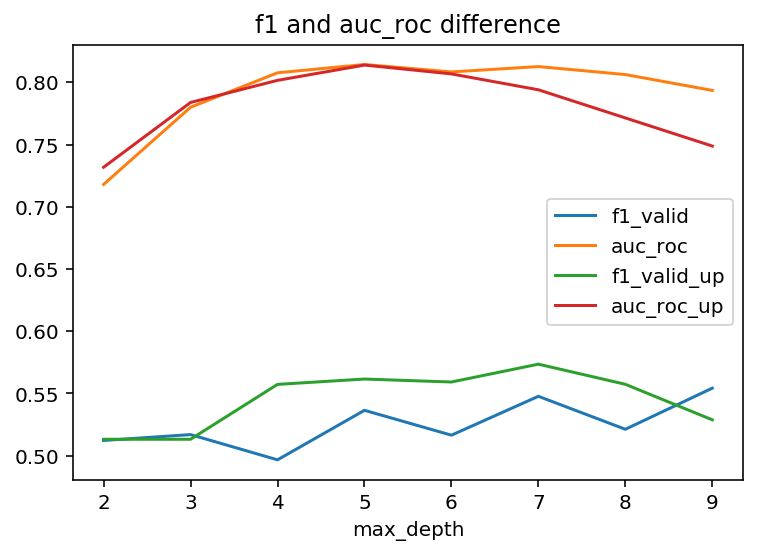

In [33]:
# plot graphs
des_tree_up_scores_sum.plot(x='max_depth', title='f1 and auc_roc difference');

*Make dataframe with accuracy*

In [34]:
des_tree_acc = des_tree[['max_depth', 'train_accuracy', 'valid_accuracy']]
des_tree_up_acc = des_tree_up[['max_depth', 'train_accuracy_up', 'valid_accuracy_up']]
des_tree_up_acc_sum = des_tree_acc.assign(**des_tree_up_acc)
des_tree_up_acc_sum.head()

,max_depth,train_accuracy,valid_accuracy,train_accuracy_up,valid_accuracy_up
0,2,0.840117,0.823982,0.721385,0.725523
1,3,0.845618,0.827283,0.721385,0.725523
2,4,0.857352,0.834983,0.754284,0.749175
3,5,0.866703,0.835534,0.775417,0.727723
4,6,0.872754,0.838284,0.801805,0.762376


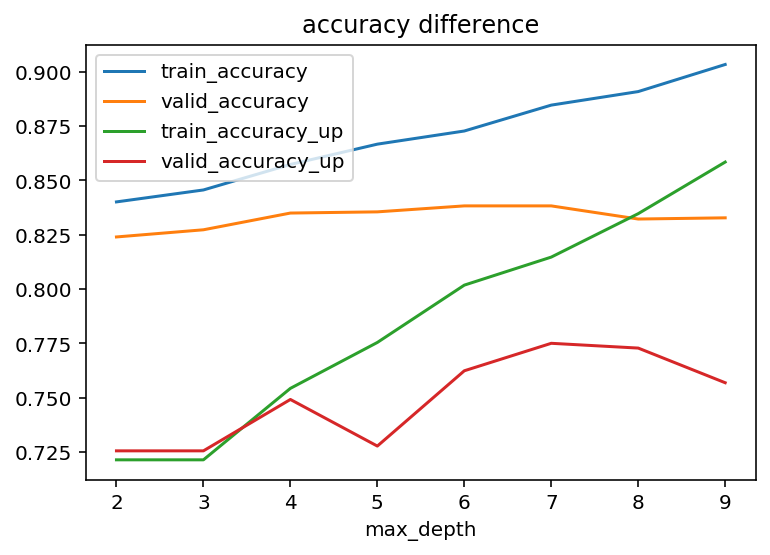

In [35]:
des_tree_up_acc_sum.plot(x='max_depth', title='accuracy difference');

### Conclusion

As we see accuracy was higher before preprocessing. F1 has growth. And auc_roc don't show the high growth.

### Step 7. Check the quality of the model

*Check the quality of the model using the test set.*

In [36]:
model = GradientBoostingClassifier(random_state=12345, max_depth=5, n_estimators=47)
model.fit(features_train_upsampled, target_train_upsampled) # fit the model
predicted_test = model.predict(features_test)

# predict probabilities
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

# calculate auc_roc
auc_roc = roc_auc_score(target_test, probabilities_one_test) 

f1_test = f1_score(target_test, predicted_test) # count the test score
print('f1_score:', f1_test)
print('auc_roc:', auc_roc)

f1_score: 0.5937859608745686
auc_roc: 0.8530708843223275


### Conclusion

This's good f1_score and auc_roc.

### Step 4. Overall conclusion

*The main task:*

For classification task, we need to predict whether a customer will leave the bank soon.

*Conclusion:*

We have identified that "GradientBoostingClassifier" with max_depth=5 and n_estimators=47 is the best model for our conditions.